In [ ]:
!pip install kaggle

In [ ]:
!mkdir kaggle

In [ ]:
import os
import json 
kaggleAPIToken = {"username":"phamnguyenduytien","key":"f14e7d8f0e3aec14b3b1b60a3eaaf7e9"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(kaggleAPIToken, file)

In [ ]:
!chmod 600 /content/kaggle/kaggle.json
!sudo mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d phamnguyenduytien/alzheimers-disease-5-classes

 33% 5.00M/14.9M [00:00<00:00, 24.5MB/s]
100% 14.9M/14.9M [00:00<00:00, 59.8MB/s]


In [ ]:
!unzip /content/alzheimers-disease-5-classes.zip

Archive:  /content/alzheimers-disease-5-classes.zip
  inflating: Alzheimer 5 classes/test/Mild/mildDem (1).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (10).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (11).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (12).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (13).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (14).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (15).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (16).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (17).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (18).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (19).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (2).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (20).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (21).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (22).jpg  
  inflating: Alzheim

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
base_path = "/content/Alzheimer 5 classes/train/"

In [ ]:
categories = ['MildDemented','ModerateDemented','NonDemented','SevereDemented','VeryMildDemented']

In [ ]:
## Thêm class vào dataframe
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [ ]:
## Đọc base file rồi tạo Dataframe
filenames_list = []
categories_list = []

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = pd.DataFrame(columns= ['image_path','category'])

for category in categories:
    filenames = os.listdir(base_path + category + "/")
    for filename in filenames:
        file_path = base_path + category+"/"+filename
        df2 = {'image_path': file_path, 'category': category}
        df = df.append(df2, ignore_index = True)

**In các ảnh ngẫu nhiên**

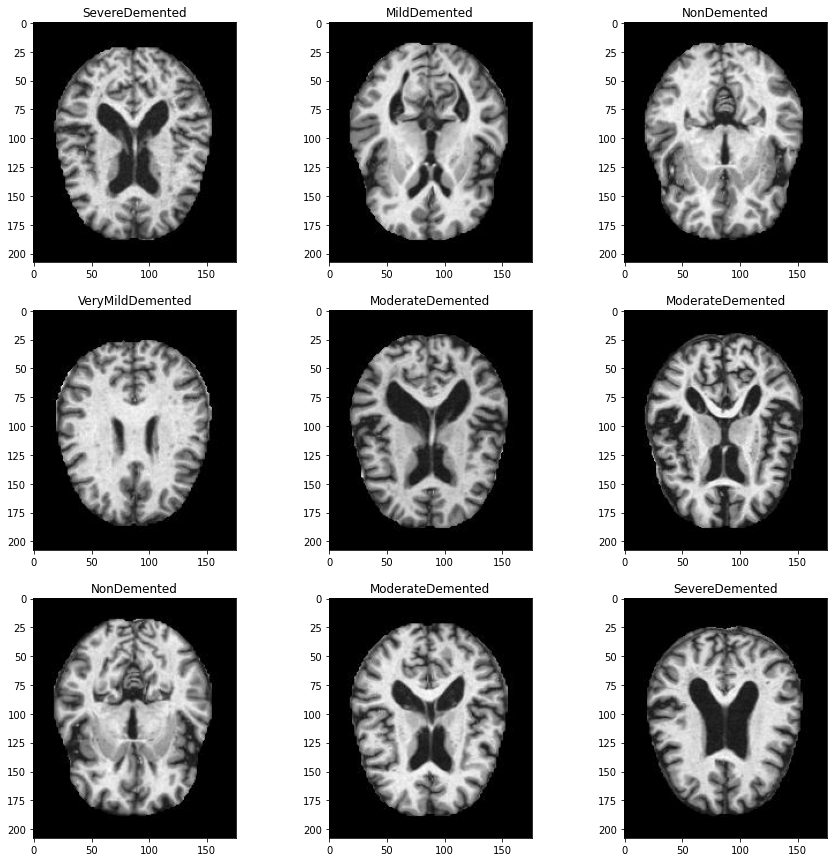

In [ ]:
## in ngẫu nhiên 9 ảnh từ trong dataset và class tương ứng
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(sample['image_path'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

**Biểu đồ phân bố**

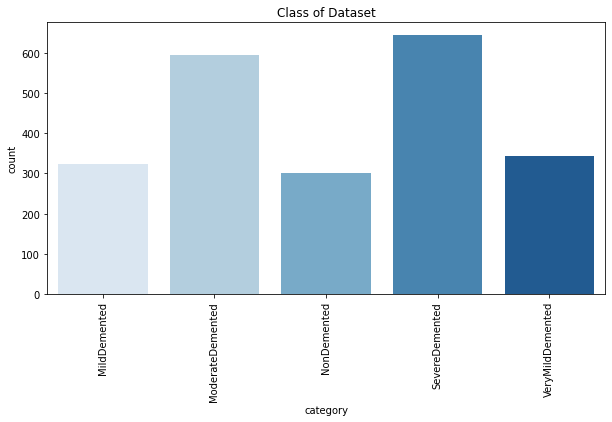

In [ ]:
## Vẽ biểu đồ phân bố số lượng ảnh ở mỗi class
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Class of Dataset')
plt.show()

Quan sát biểu đồ ta thấy dữ liệu bị imbalanced ở hai cột "Moderate Demented" và "Severe Demented" nên ta sẽ drop hai cột này

In [ ]:
moderateDrop=df[df['category']=='ModerateDemented'].sample(n=200)
severeDrop=df[df['category']=='SevereDemented'].sample(n=200)
df.drop(labels=moderateDrop.index.values, inplace=True)
df.drop(labels=severeDrop.index.values, inplace=True)

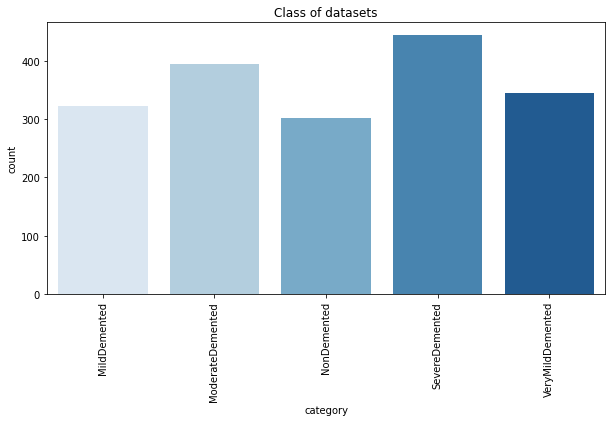

In [ ]:
## Sau khi xử drop vẽ lại đồ thị để quan sát
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Class of datasets')
plt.show()

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(1446, 181, 181)

**CNN**

In [ ]:
im_shape = (256,256)
batch_size = 64
seed = 42

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1446 validated image filenames belonging to 5 classes.


In [ ]:
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 181 validated image filenames belonging to 5 classes.


In [ ]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 181 validated image filenames belonging to 5 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'SevereDemented', 'VeryMildDemented']


**MODEL**

In [43]:
from tensorflow.keras.optimizers import SGD

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      

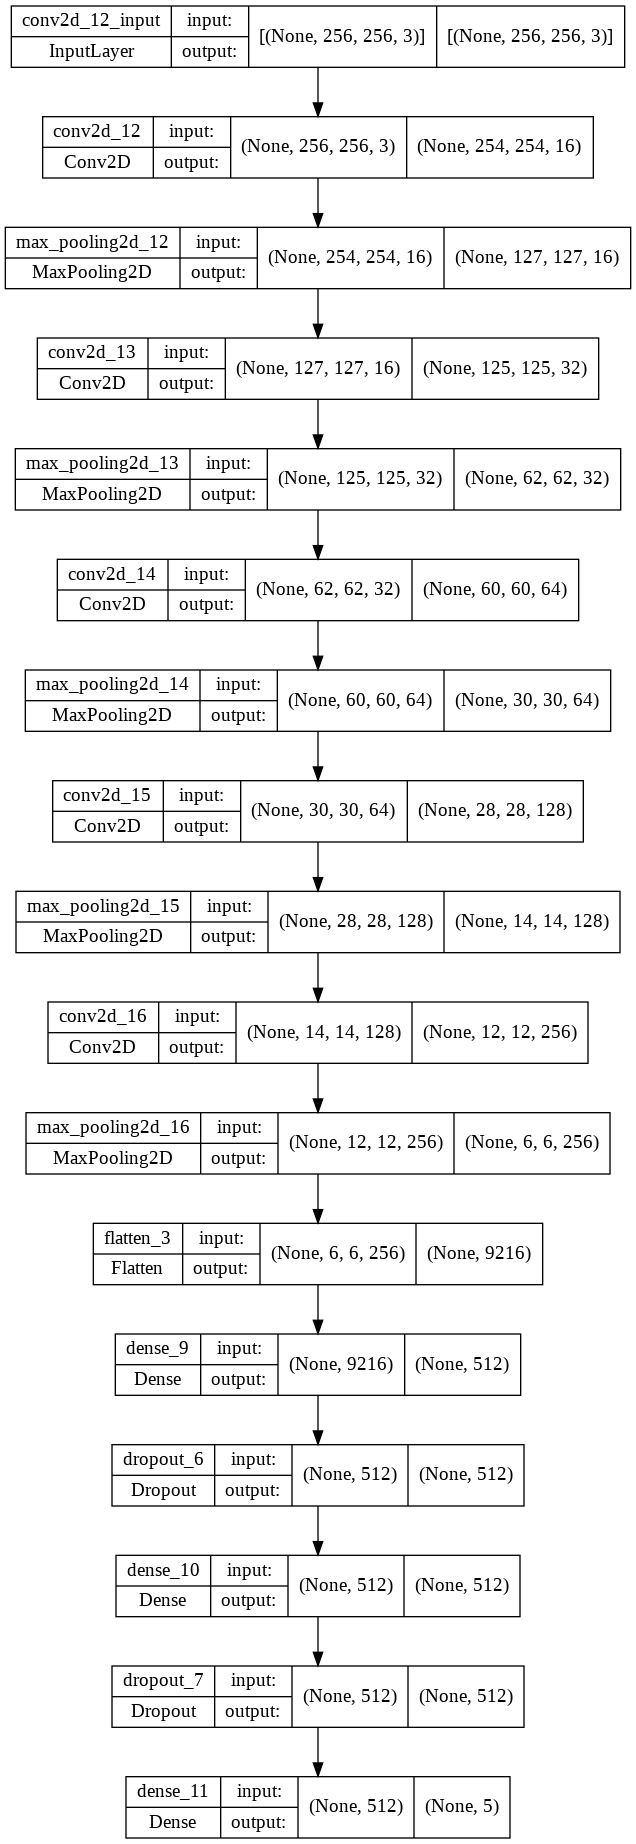

In [47]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


#  Hiển thị hàm model.summary() dưới dạng biểu đồ 
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True)


In [48]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [49]:
epochs = 100
# Hàm callback để lưu lại model nào tốt nhất
callbacks_list = [ModelCheckpoint(filepath='model_5classes.hdf5',monitor='val_loss', save_best_only=True, verbose=1),EarlyStopping(monitor='val_loss', patience=10,verbose=1)]
#Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.6083 - accuracy: 0.2417
Epoch 1: val_loss improved from inf to 1.53412, saving model to model_5classes.hdf5
22/22 [==============================] - 100s 4s/step - loss: 1.6083 - accuracy: 0.2417 - val_loss: 1.5341 - val_accuracy: 0.2969
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 1.1343 - accuracy: 0.5210
Epoch 2: val_loss improved from 1.53412 to 0.43237, saving model to model_5classes.hdf5
22/22 [==============================] - 99s 4s/step - loss: 1.1343 - accuracy: 0.5210 - val_loss: 0.4324 - val_accuracy: 0.8828
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8603
Epoch 3: val_loss improved from 0.43237 to 0.24269, saving model to model_5classes.hdf5
22/22 [==============================] - 99s 4s/step - loss: 0.3842 - accuracy: 0.8603 - val_loss: 0.2427 - val_accuracy: 0.9062
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss

### Đánh giá mô hình

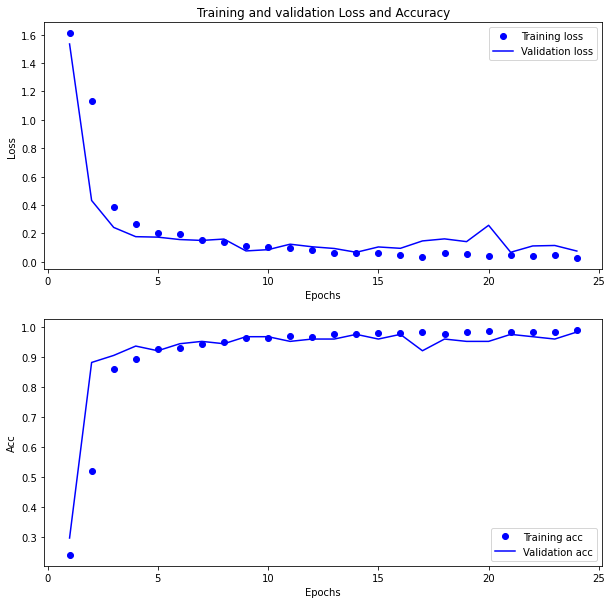

In [50]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [51]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

3/3 [==============================] - 4s 1s/step - loss: 0.1071 - accuracy: 0.9779
Val loss: 0.10705655813217163
Val accuracy: 0.9779005646705627


In [52]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

181/181 [==============================] - 5s 30ms/step - loss: 0.1332 - accuracy: 0.9724
Test loss: 0.13318726420402527
Test accuracy: 0.9723756909370422


In [53]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification Report
                  precision    recall  f1-score   support

    MildDemented       1.00      0.92      0.96        37
ModerateDemented       0.96      1.00      0.98        44
     NonDemented       0.88      0.96      0.92        24
  SevereDemented       1.00      1.00      1.00        39
VeryMildDemented       1.00      0.97      0.99        37

        accuracy                           0.97       181
       macro avg       0.97      0.97      0.97       181
    weighted avg       0.97      0.97      0.97       181



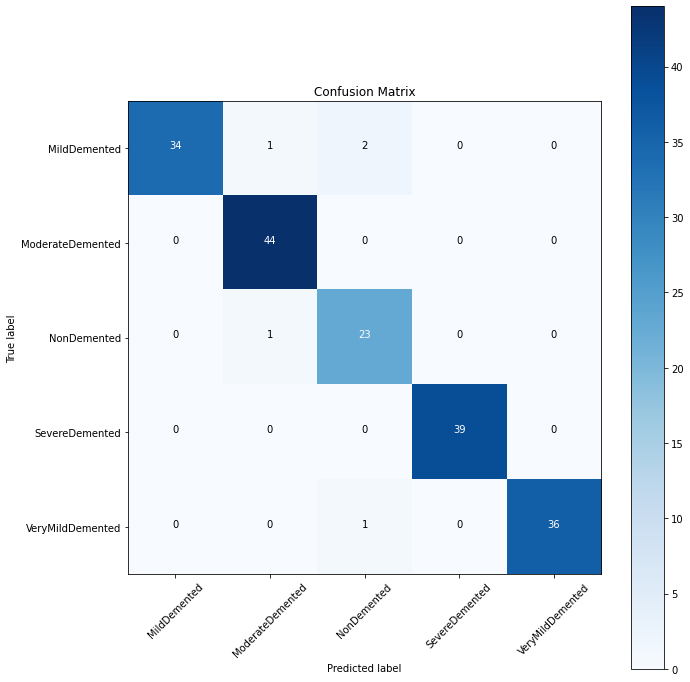

In [54]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

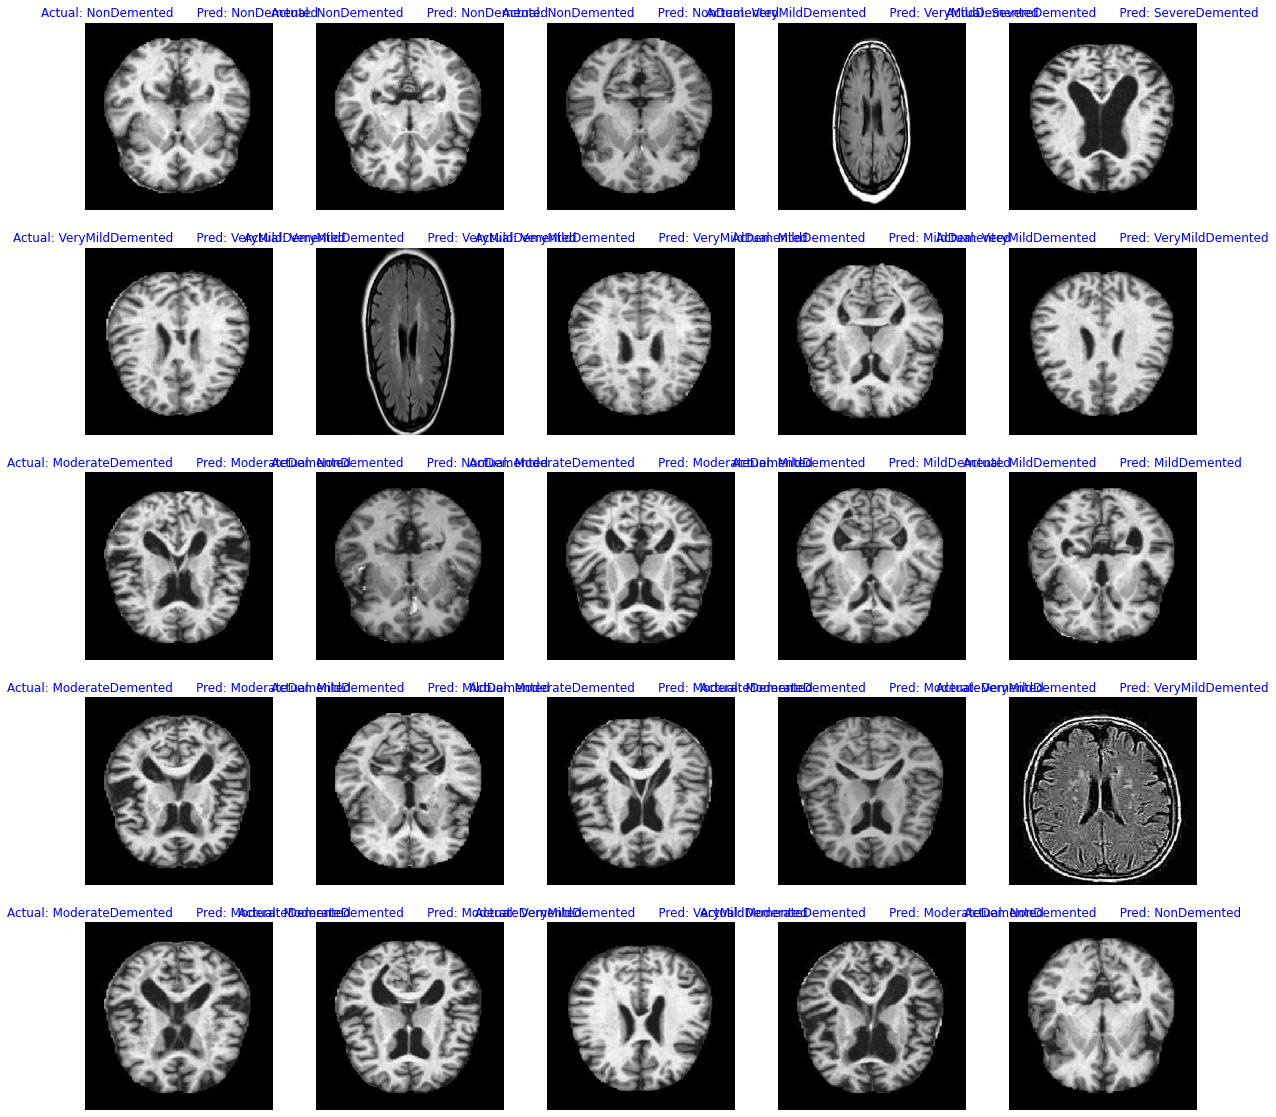

In [55]:
def test_image_samples(gen ):
    
        t_dict=gen.class_indices
        classes=list(t_dict.keys())    
        images,labels=next(gen) # get a sample batch from the generator 
        preds = model.predict(images)
        preds = preds.argmax(1)
        plt.figure(figsize=(20, 20))
        length=len(labels)
        if length<25:   #show maximum of 25 images
            r=length
        else:
            r=25
        for i in range(r):
            plt.subplot(5, 5, i + 1)
            image=images[i]
            plt.imshow(image)
            index=np.argmax(labels[i])
            class_name=classes[index]
            class_name_pred=classes[preds[i]]
            plt.title('Actual: {}      Pred: {}'.format(class_name,class_name_pred),  color='blue', fontsize=12)
            plt.axis('off')
        plt.show()

test_image_samples(val_generator)

In [ ]:
model.save('model_5classes.h5')

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_5classes.h5')

In [ ]:
model = load_model('model_5classes.h5')

In [ ]:
import cv2 as cv
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

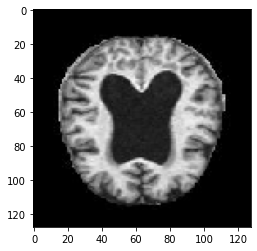

In [ ]:
img = load_img('/content/27 (4).jpg',target_size=(128,128))
plt.imshow(img)
img = img_to_array(img)

In [ ]:
img = cv.resize(img, dsize=(256, 256))
img = img.astype('float')*1./255
# Convert to tensor
img = np.expand_dims(img, axis=0)

In [ ]:
class_name = ['MildDemented','ModerateDemented','NonDemented','SevereDemented','VeryMildDemented']

In [ ]:
model_5 = load_model('model_5classes.h5')
predict = model_5.predict(img)
class_name[np.argmax(predict[0])], (predict[0])

('SevereDemented',
 array([9.1014112e-09, 4.2890815e-06, 1.5521213e-10, 9.9999523e-01,
        5.1590189e-07], dtype=float32))